In [5]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.ensemble import IsolationForest
# from prophet import Prophet
# from joblib import Parallel, delayed
# import warnings
# import os
# import numpy as np
# from sklearn.preprocessing import StandardScaler

# # Suppress warnings for cleaner output
# warnings.filterwarnings('ignore')

# # -----------------------------
# # Step 1: Load and Preprocess Data
# # -----------------------------

# # Load the dataset
# file_path = 'dataset.csv'
# data = pd.read_csv(file_path)

# # Ensure 'Customer No' or similar identifier is present
# if 'Customer No' not in data.columns:
#     # If not present, create a unique identifier for each customer
#     data.reset_index(inplace=True)
#     data.rename(columns={'index': 'Customer No'}, inplace=True)

# # Identify postpaid and prepaid columns based on column naming
# postpaid_columns = [col for col in data.columns if 'post_' in col]
# prepaid_columns = [col for col in data.columns if 'pre_' in col]

# # Convert relevant columns to numeric and handle errors
# data[postpaid_columns + prepaid_columns] = data[postpaid_columns + prepaid_columns].apply(pd.to_numeric, errors='coerce')

# # Drop rows with excessive NaNs
# threshold = int(len(postpaid_columns + prepaid_columns) * 0.5)
# data_cleaned = data.dropna(thresh=threshold)

# # -----------------------------
# # Step 2: Define Functions
# # -----------------------------

# def prepare_prophet_data(customer_series, columns):
#     """
#     Prepare a DataFrame suitable for Prophet modeling for a single customer.
#     """
#     # Create a date range based on the number of periods
#     start_date = '2020-01-01'  # Adjust as necessary
#     df = pd.DataFrame({
#         'ds': pd.date_range(start=start_date, periods=len(columns), freq='M'),
#         'y': customer_series[columns].values
#     })
#     return df

# def process_customer(customer_id, customer_data):
#     """
#     Process data for a single customer: fit Prophet models and collect residuals.
#     """
#     residuals_list = []

#     # Process both postpaid and prepaid data
#     for columns in [postpaid_columns, prepaid_columns]:
#         customer_columns = [col for col in columns if col in customer_data.index]
#         if not customer_data[customer_columns].isnull().all():
#             prophet_data = prepare_prophet_data(customer_data, customer_columns)
#             prophet_data.dropna(inplace=True)
#             if len(prophet_data) > 2:
#                 model = Prophet(
#                     yearly_seasonality=False,
#                     weekly_seasonality=False,
#                     daily_seasonality=False,
#                     n_changepoints=5,
#                     seasonality_mode='additive',
#                     mcmc_samples=0
#                 )
#                 model.fit(prophet_data)
#                 forecast = model.predict(prophet_data)
#                 residuals = prophet_data['y'] - forecast['yhat']

#                 # Remove NaNs from residuals
#                 residuals = residuals.dropna()
#                 residuals_list.extend(residuals.values)
#             else:
#                 continue  # Skip if not enough data points
#         else:
#             continue  # Skip if all data is null

#     # Remove NaNs from residuals_list
#     residuals_list = [resid for resid in residuals_list if not np.isnan(resid)]

#     if len(residuals_list) == 0:
#         # No valid residuals after removing NaNs
#         return None

#     return {
#         'Customer No': customer_id,
#         'Residuals': residuals_list,
#     }

# # -----------------------------
# # Step 3: Process Customers Using Joblib for Parallel Processing
# # -----------------------------

# def main():
#     # Prepare data for parallel processing
#     customer_list = [(row['Customer No'], row) for _, row in data_cleaned.iterrows()]

#     # Number of CPU cores to use
#     num_cores = os.cpu_count()

#     # Use joblib's Parallel
#     results = Parallel(n_jobs=num_cores)(
#         delayed(process_customer)(customer_id, customer_data) for customer_id, customer_data in customer_list
#     )

#     # Filter out None results
#     results = [res for res in results if res is not None]

#     # Convert results to DataFrame
#     residuals_df = pd.DataFrame(results)

#     # -----------------------------
#     # Step 4: Aggregate Residuals and Fit Isolation Forest
#     # -----------------------------

#     # Combine all residuals
#     all_residuals = np.concatenate(residuals_df['Residuals'].values)
#     all_residuals = all_residuals.reshape(-1, 1)

#     # Remove NaNs from all_residuals (additional safety check)
#     mask = ~np.isnan(all_residuals).flatten()
#     all_residuals = all_residuals[mask]

#     # Standardize residuals
#     scaler = StandardScaler()
#     residuals_scaled = scaler.fit_transform(all_residuals.reshape(-1, 1))

#     # Fit Isolation Forest
#     iso_forest = IsolationForest(contamination=0.01, random_state=42)
#     iso_forest.fit(residuals_scaled)

#     # Predict anomalies
#     anomaly_labels = iso_forest.predict(residuals_scaled)
#     anomaly_scores = iso_forest.decision_function(residuals_scaled)

#     # Map anomaly labels back to customers
#     residuals_lengths = residuals_df['Residuals'].apply(len).values

#     # Split anomaly_labels and anomaly_scores back into per-customer lists
#     anomaly_labels_split = np.split(anomaly_labels, np.cumsum(residuals_lengths)[:-1])
#     anomaly_scores_split = np.split(anomaly_scores, np.cumsum(residuals_lengths)[:-1])

#     # Add these back to residuals_df
#     residuals_df['Anomaly Labels'] = anomaly_labels_split
#     residuals_df['Anomaly Scores'] = anomaly_scores_split

#     # Determine 'Has Anomaly' per customer
#     residuals_df['Has Anomaly'] = residuals_df['Anomaly Labels'].apply(lambda x: int(any(label == -1 for label in x)))

#     # -----------------------------
#     # Step 5: Analyze and Save Results
#     # -----------------------------

#     # Save anomalies to CSV
#     residuals_df.to_csv('Prophet+IF_anomalies_detected.csv', index=False)

#     # Count the number of customers with anomalies
#     num_anomalies = residuals_df['Has Anomaly'].sum()
#     print(f"Number of customers with anomalies detected: {num_anomalies}")

#     # Identify customers with and without anomalies
#     anomalous_customers = residuals_df[residuals_df['Has Anomaly'] == 1]['Customer No'].tolist()
#     normal_customers = residuals_df[residuals_df['Has Anomaly'] == 0]['Customer No'].tolist()

#     # Save normal customers to CSV
#     normal_customers_df = data_cleaned[data_cleaned['Customer No'].isin(normal_customers)]
#     normal_customers_df.to_csv('Prophet+IF_normal_customers.csv', index=False)

#     # Identify top anomalous customers based on total anomalies
#     residuals_df['Total Anomalies'] = residuals_df['Anomaly Labels'].apply(lambda x: sum(1 for label in x if label == -1))
#     top_anomalous_customers = residuals_df.sort_values('Total Anomalies', ascending=False).head(5)

#     # -----------------------------
#     # Step 6: Visualization
#     # -----------------------------

#     # Create directory for plots if it doesn't exist
#     if not os.path.exists('plots'):
#         os.makedirs('plots')

#     # Visualization for Top Anomalous Customers
#     plt.figure(figsize=(12, 8))
#     for idx, row in top_anomalous_customers.iterrows():
#         customer_id = row['Customer No']
#         residuals = row['Residuals']
#         anomaly_labels = row['Anomaly Labels']
#         timestamps = range(len(residuals))

#         plt.plot(timestamps, residuals, label=f'Customer {customer_id}', marker='o')
#         anomaly_indices = [i for i, label in enumerate(anomaly_labels) if label == -1]
#         plt.scatter([timestamps[i] for i in anomaly_indices],
#                     [residuals[i] for i in anomaly_indices], color='red')

#     plt.title('Residuals for Top Anomalous Customers')
#     plt.xlabel('Time Index')
#     plt.ylabel('Residuals (Actual - Forecast)')
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig('plots/Prophet+IF_Top_Anomalous_Customers.png', dpi=300)
#     plt.show()

#     # Plotting the number of anomalies per customer
#     residuals_df.sort_values('Total Anomalies', ascending=False, inplace=True)

#     plt.figure(figsize=(10, 6))
#     plt.bar(residuals_df['Customer No'].astype(str), residuals_df['Total Anomalies'])
#     plt.title('Total Number of Anomalies Detected per Customer')
#     plt.xlabel('Customer No')
#     plt.ylabel('Number of Anomalies')
#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.savefig('plots/Prophet+IF_Anomalies_Per_Customer.png', dpi=300)
#     plt.show()

#     # Save full data with both anomalies and normal data to a CSV file
#     data_cleaned.to_csv('Prophet+IF_full_data_with_anomalies.csv', index=False)

# if __name__ == '__main__':
#     main()


In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.ensemble import IsolationForest
# from prophet import Prophet
# from joblib import Parallel, delayed
# import warnings
# import os
# import numpy as np
# from sklearn.preprocessing import StandardScaler

# # Suppress warnings for cleaner output
# warnings.filterwarnings('ignore')

# # -----------------------------
# # Step 1: Load and Preprocess Data
# # -----------------------------

# # Load the dataset
# file_path = 'dataset.csv'
# data = pd.read_csv(file_path)

# # Ensure 'Customer No' or similar identifier is present
# if 'Customer No' not in data.columns:
#     # If not present, create a unique identifier for each customer
#     data.reset_index(inplace=True)
#     data.rename(columns={'index': 'Customer No'}, inplace=True)

# # Identify postpaid and prepaid columns based on column naming
# postpaid_columns = [col for col in data.columns if 'post_' in col]
# prepaid_columns = [col for col in data.columns if 'pre_' in col]

# # Convert relevant columns to numeric and handle errors
# data[postpaid_columns + prepaid_columns] = data[postpaid_columns + prepaid_columns].apply(pd.to_numeric, errors='coerce')

# # Drop rows with excessive NaNs
# threshold = int(len(postpaid_columns + prepaid_columns) * 0.5)
# data_cleaned = data.dropna(thresh=threshold)

# # -----------------------------
# # Step 2: Define Functions
# # -----------------------------

# def prepare_prophet_data(customer_series, columns):
#     """
#     Prepare a DataFrame suitable for Prophet modeling for a single customer.
#     """
#     # Create a date range based on the number of periods
#     start_date = '2020-01-01'  # Adjust as necessary
#     df = pd.DataFrame({
#         'ds': pd.date_range(start=start_date, periods=len(columns), freq='M'),
#         'y': customer_series[columns].values
#     })
#     return df

# def process_customer(customer_id, customer_data):
#     """
#     Process data for a single customer: fit Prophet models and collect residuals.
#     """
#     residuals_list = []

#     # Process both postpaid and prepaid data
#     for columns in [postpaid_columns, prepaid_columns]:
#         customer_columns = [col for col in columns if col in customer_data.index]
#         if not customer_data[customer_columns].isnull().all():
#             prophet_data = prepare_prophet_data(customer_data, customer_columns)
#             prophet_data.dropna(inplace=True)
#             if len(prophet_data) > 2:
#                 model = Prophet(
#                     yearly_seasonality=False,
#                     weekly_seasonality=False,
#                     daily_seasonality=False,
#                     n_changepoints=5,
#                     seasonality_mode='additive',
#                     mcmc_samples=0
#                 )
#                 model.fit(prophet_data)
#                 forecast = model.predict(prophet_data)
#                 residuals = prophet_data['y'] - forecast['yhat']

#                 # Remove NaNs from residuals
#                 residuals = residuals.dropna()
#                 residuals_list.extend(residuals.values)
#             else:
#                 continue  # Skip if not enough data points
#         else:
#             continue  # Skip if all data is null

#     # Remove NaNs from residuals_list
#     residuals_list = [resid for resid in residuals_list if not np.isnan(resid)]

#     if len(residuals_list) == 0:
#         # No valid residuals after removing NaNs
#         return None

#     return {
#         'Customer No': customer_id,
#         'Residuals': residuals_list,
#     }

# # -----------------------------
# # Step 3: Process Customers Using Joblib for Parallel Processing
# # -----------------------------

# def main():
#     # Prepare data for parallel processing
#     customer_list = [(row['Customer No'], row) for _, row in data_cleaned.iterrows()]

#     # Number of CPU cores to use
#     num_cores = os.cpu_count()

#     # Use joblib's Parallel
#     results = Parallel(n_jobs=num_cores)(
#         delayed(process_customer)(customer_id, customer_data) for customer_id, customer_data in customer_list
#     )

#     # Filter out None results
#     results = [res for res in results if res is not None]

#     # Convert results to DataFrame
#     residuals_df = pd.DataFrame(results)

#     # -----------------------------
#     # -----------------------------
#     # Step 4: Aggregate Residuals and Fit Isolation Forest at Customer Level
#     # -----------------------------

#     # Aggregate residuals per customer
#     residuals_df['Mean Residual'] = residuals_df['Residuals'].apply(np.mean)
#     residuals_df['Std Residual'] = residuals_df['Residuals'].apply(np.std)
#     residuals_df['Max Residual'] = residuals_df['Residuals'].apply(np.max)
#     residuals_df['Min Residual'] = residuals_df['Residuals'].apply(np.min)

#     # Select features for Isolation Forest
#     customer_features = residuals_df[['Mean Residual', 'Std Residual', 'Max Residual', 'Min Residual']].dropna()

#     # Standardize customer features
#     scaler = StandardScaler()
#     features_scaled = scaler.fit_transform(customer_features)

#     # Fit Isolation Forest with contamination=0.01 (1% anomalies)
#     iso_forest = IsolationForest(contamination=0.05, random_state=42)
#     iso_forest.fit(features_scaled)

#     # Predict anomalies
#     customer_features['Anomaly Label'] = iso_forest.predict(features_scaled)
#     customer_features['Has Anomaly'] = customer_features['Anomaly Label'].apply(lambda x: 1 if x == -1 else 0)

#     # Merge back to residuals_df
#     residuals_df = residuals_df.merge(customer_features[['Anomaly Label', 'Has Anomaly']], left_index=True, right_index=True)

#     # -----------------------------
#     # Step 5: Analyze and Save Results
#     # -----------------------------

#     # Save anomalies to CSV
#     residuals_df.to_csv('Prophet+IF_anomalies_detected.csv', index=False)

#     # Count the number of customers with anomalies
#     num_anomalies = residuals_df['Has Anomaly'].sum()
#     print(f"Number of customers with anomalies detected: {num_anomalies}")

#     # Identify customers with and without anomalies
#     anomalous_customers = residuals_df[residuals_df['Has Anomaly'] == 1]['Customer No'].tolist()
#     normal_customers = residuals_df[residuals_df['Has Anomaly'] == 0]['Customer No'].tolist()

#     # Save normal customers to CSV
#     normal_customers_df = data_cleaned[data_cleaned['Customer No'].isin(normal_customers)]
#     normal_customers_df.to_csv('Prophet+IF_normal_customers.csv', index=False)

#     # Identify top anomalous customers based on total anomalies
#     residuals_df['Total Anomalies'] = residuals_df['Residuals'].apply(lambda x: sum(1 for resid in x if resid < some_threshold))  # Adjust threshold as needed
#     top_anomalous_customers = residuals_df.sort_values('Total Anomalies', ascending=False).head(5)

#     # Continue with Visualization...

#     # -----------------------------
#     # Step 5: Analyze and Save Results
#     # -----------------------------

#     # Save anomalies to CSV
#     residuals_df.to_csv('Prophet+IF_anomalies_detected.csv', index=False)

#     # Count the number of customers with anomalies
#     num_anomalies = residuals_df['Has Anomaly'].sum()
#     print(f"Number of customers with anomalies detected: {num_anomalies}")

#     # Identify customers with and without anomalies
#     anomalous_customers = residuals_df[residuals_df['Has Anomaly'] == 1]['Customer No'].tolist()
#     normal_customers = residuals_df[residuals_df['Has Anomaly'] == 0]['Customer No'].tolist()

#     # Save normal customers to CSV
#     normal_customers_df = data_cleaned[data_cleaned['Customer No'].isin(normal_customers)]
#     normal_customers_df.to_csv('Prophet+IF_normal_customers.csv', index=False)

#     # Identify top anomalous customers based on total anomalies
#     residuals_df['Total Anomalies'] = residuals_df['Anomaly Labels'].apply(lambda x: sum(1 for label in x if label == -1))
#     top_anomalous_customers = residuals_df.sort_values('Total Anomalies', ascending=False).head(5)

#     # -----------------------------
#     # Step 6: Visualization
#     # -----------------------------

#     # Create directory for plots if it doesn't exist
#     if not os.path.exists('plots'):
#         os.makedirs('plots')

#     # Visualization for Top Anomalous Customers
#     plt.figure(figsize=(12, 8))
#     for idx, row in top_anomalous_customers.iterrows():
#         customer_id = row['Customer No']
#         residuals = row['Residuals']
#         anomaly_labels = row['Anomaly Labels']
#         timestamps = range(len(residuals))

#         plt.plot(timestamps, residuals, label=f'Customer {customer_id}', marker='o')
#         anomaly_indices = [i for i, label in enumerate(anomaly_labels) if label == -1]
#         plt.scatter([timestamps[i] for i in anomaly_indices],
#                     [residuals[i] for i in anomaly_indices], color='red')

#     plt.title('Residuals for Top Anomalous Customers')
#     plt.xlabel('Time Index')
#     plt.ylabel('Residuals (Actual - Forecast)')
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig('plots/Prophet+IF_Top_Anomalous_Customers.png', dpi=300)
#     plt.show()

#     # Plotting the number of anomalies per customer
#     residuals_df.sort_values('Total Anomalies', ascending=False, inplace=True)

#     plt.figure(figsize=(10, 6))
#     plt.bar(residuals_df['Customer No'].astype(str), residuals_df['Total Anomalies'])
#     plt.title('Total Number of Anomalies Detected per Customer')
#     plt.xlabel('Customer No')
#     plt.ylabel('Number of Anomalies')
#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.savefig('plots/Prophet+IF_Anomalies_Per_Customer.png', dpi=300)
#     plt.show()

#     # Save full data with both anomalies and normal data to a CSV file
#     data_cleaned.to_csv('Prophet+IF_full_data_with_anomalies.csv', index=False)

# if __name__ == '__main__':
#     main()


AUC Score: 0.5033


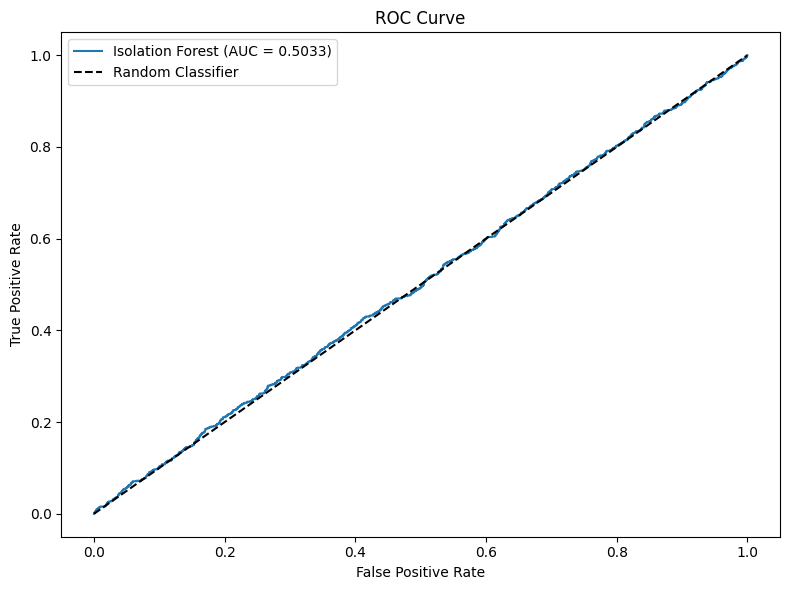


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16876
           1       0.06      0.06      0.06       888

    accuracy                           0.91     17764
   macro avg       0.50      0.50      0.50     17764
weighted avg       0.91      0.91      0.91     17764

Number of customers with anomalies detected: 889


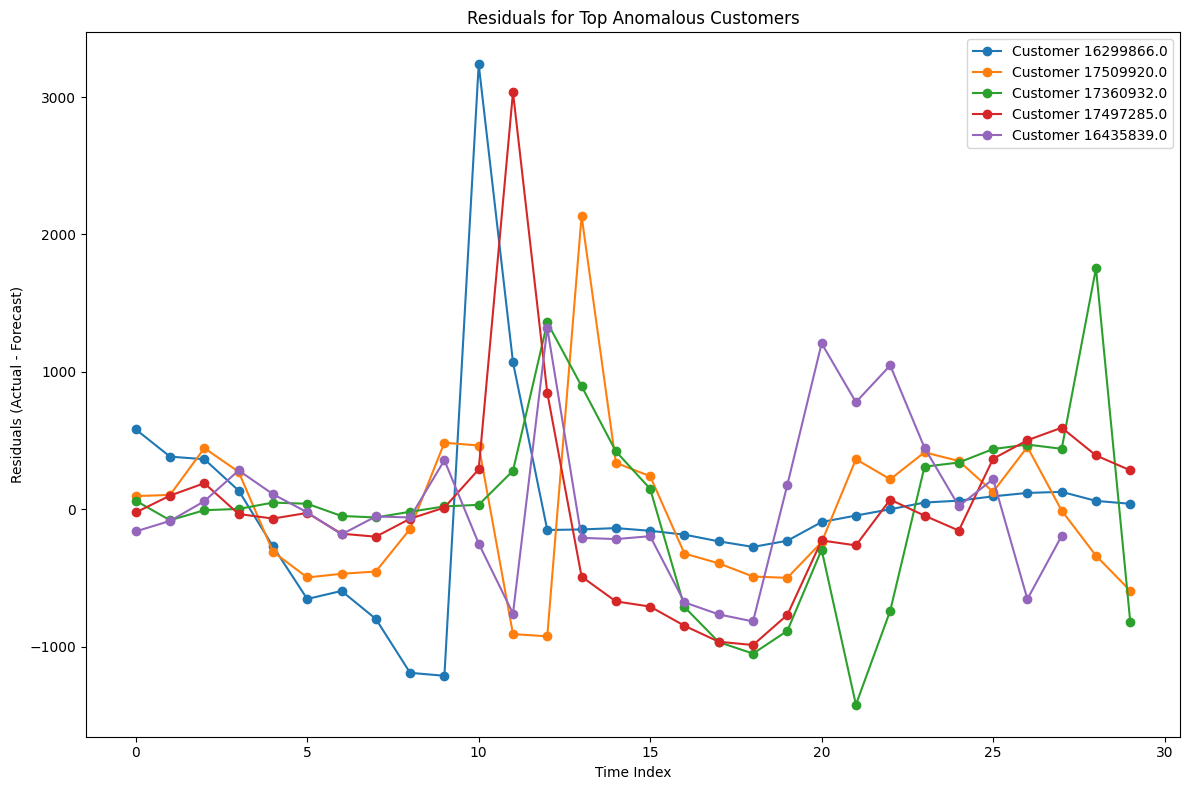

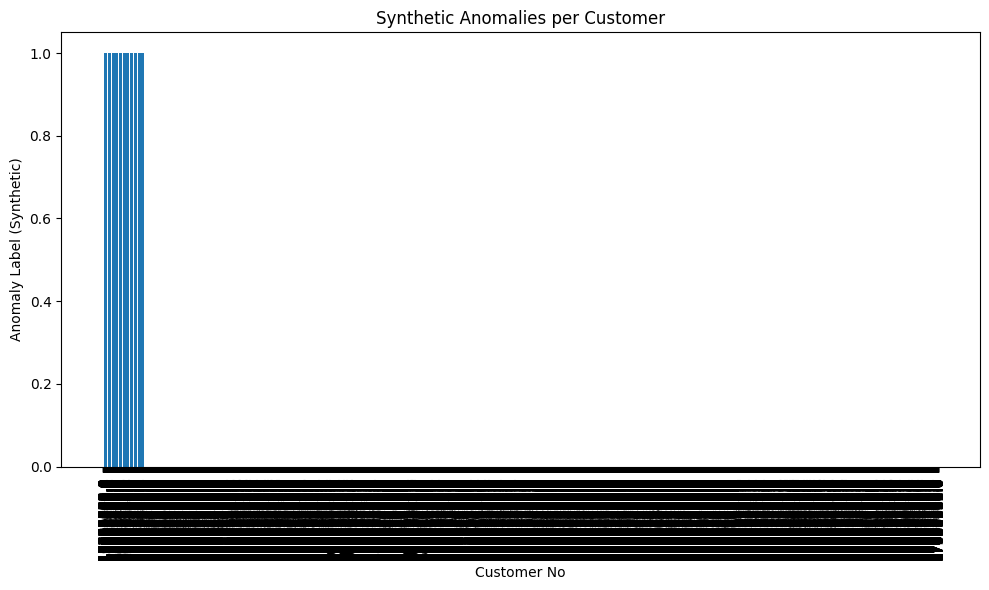

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from prophet import Prophet
from joblib import Parallel, delayed
import warnings
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -----------------------------
# Step 1: Load and Preprocess Data
# -----------------------------

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Ensure 'Customer No' or similar identifier is present
if 'Customer No' not in data.columns:
    # If not present, create a unique identifier for each customer
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Customer No'}, inplace=True)

# Identify postpaid and prepaid columns based on column naming
postpaid_columns = [col for col in data.columns if 'post_' in col]
prepaid_columns = [col for col in data.columns if 'pre_' in col]

# Convert relevant columns to numeric and handle errors
data[postpaid_columns + prepaid_columns] = data[postpaid_columns + prepaid_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with excessive NaNs
threshold = int(len(postpaid_columns + prepaid_columns) * 0.5)
data_cleaned = data.dropna(thresh=threshold)

# -----------------------------
# Step 2: Define Functions
# -----------------------------

def prepare_prophet_data(customer_series, columns):
    """
    Prepare a DataFrame suitable for Prophet modeling for a single customer.
    """
    # Create a date range based on the number of periods
    start_date = '2020-01-01'  # Adjust as necessary
    df = pd.DataFrame({
        'ds': pd.date_range(start=start_date, periods=len(columns), freq='M'),
        'y': customer_series[columns].values
    })
    return df

def process_customer(customer_id, customer_data):
    """
    Process data for a single customer: fit Prophet models and collect residuals.
    """
    residuals_list = []

    # Process both postpaid and prepaid data
    for columns in [postpaid_columns, prepaid_columns]:
        customer_columns = [col for col in columns if col in customer_data.index]
        if not customer_data[customer_columns].isnull().all():
            prophet_data = prepare_prophet_data(customer_data, customer_columns)
            prophet_data.dropna(inplace=True)
            if len(prophet_data) > 2:
                model = Prophet(
                    yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    n_changepoints=5,
                    seasonality_mode='additive',
                    mcmc_samples=0
                )
                model.fit(prophet_data)
                forecast = model.predict(prophet_data)
                residuals = prophet_data['y'] - forecast['yhat']

                # Remove NaNs from residuals
                residuals = residuals.dropna()
                residuals_list.extend(residuals.values)
            else:
                continue  # Skip if not enough data points
        else:
            continue  # Skip if all data is null

    # Remove NaNs from residuals_list
    residuals_list = [resid for resid in residuals_list if not np.isnan(resid)]

    if len(residuals_list) == 0:
        # No valid residuals after removing NaNs
        return None

    return {
        'Customer No': customer_id,
        'Residuals': residuals_list,
    }

# -----------------------------
# Step 3: Process Customers Using Joblib for Parallel Processing
# -----------------------------

def main():
    # Prepare data for parallel processing
    customer_list = [(row['Customer No'], row) for _, row in data_cleaned.iterrows()]
    
    # Number of CPU cores to use
    num_cores = os.cpu_count()
    
    # For demonstration purposes, create synthetic ground truth labels
    # Let's assume that 5% of customers are anomalies
    np.random.seed(42)  # For reproducibility
    anomaly_fraction = 0.05
    num_customers = len(data_cleaned)
    num_anomalies = int(num_customers * anomaly_fraction)
    
    # Randomly select customers to be anomalies
    anomaly_customer_indices = np.random.choice(data_cleaned.index, size=num_anomalies, replace=False)
    
    # Create 'True Label' column
    data_cleaned['True Label'] = 0  # Initialize all as normal
    data_cleaned.loc[anomaly_customer_indices, 'True Label'] = 1  # Assign anomalies
    
    # Use joblib's Parallel to process customers
    results = Parallel(n_jobs=num_cores)(
        delayed(process_customer)(customer_id, customer_data) for customer_id, customer_data in customer_list
    )
    
    # Filter out None results
    results = [res for res in results if res is not None]
    
    # Convert results to DataFrame
    residuals_df = pd.DataFrame(results)
    
    # -----------------------------
    # Step 4: Aggregate Residuals and Fit Isolation Forest at Customer Level
    # -----------------------------
    
    # Aggregate residuals per customer
    residuals_df['Mean Residual'] = residuals_df['Residuals'].apply(np.mean)
    residuals_df['Std Residual'] = residuals_df['Residuals'].apply(np.std)
    residuals_df['Max Residual'] = residuals_df['Residuals'].apply(np.max)
    residuals_df['Min Residual'] = residuals_df['Residuals'].apply(np.min)
    
    # Select features for Isolation Forest
    customer_features = residuals_df[['Mean Residual', 'Std Residual', 'Max Residual', 'Min Residual']].dropna()
    
    # Standardize customer features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(customer_features)
    
    # Fit Isolation Forest with contamination=0.05 (5% anomalies)
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(features_scaled)
    
    # Predict anomalies
    customer_features['Anomaly Label'] = iso_forest.predict(features_scaled)
    customer_features['Has Anomaly'] = customer_features['Anomaly Label'].apply(lambda x: 1 if x == -1 else 0)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(features_scaled)
    
    # Add anomaly scores to customer_features DataFrame
    customer_features['Anomaly Score'] = anomaly_scores
    
    # Merge anomaly labels and scores back to residuals_df
    residuals_df = residuals_df.merge(
        customer_features[['Anomaly Label', 'Has Anomaly', 'Anomaly Score']],
        left_index=True,
        right_index=True
    )
    
    # Merge true labels into residuals_df
    residuals_df = residuals_df.merge(
        data_cleaned[['Customer No', 'True Label']],
        on='Customer No',
        how='left'
    )
    
    # -----------------------------
    # Step 5: Compute ROC Curve and AUC Score
    # -----------------------------
    from sklearn.metrics import roc_curve, roc_auc_score, classification_report
    
    # Extract true labels and anomaly scores
    y_true = residuals_df['True Label']
    y_scores = -residuals_df['Anomaly Score']  # Invert scores because lower scores indicate anomalies
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Compute AUC score
    auc_score = roc_auc_score(y_true, y_scores)
    
    print(f"AUC Score: {auc_score:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Isolation Forest (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/Prophet+IF_ROC_Curve.png', dpi=300)
    plt.show()
    
    # Generate classification report
    y_pred = residuals_df['Has Anomaly']
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # -----------------------------
    # Step 6: Analyze and Save Results
    # -----------------------------
    
    # Save anomalies to CSV
    residuals_df.to_csv('Prophet+IF_anomalies_detected.csv', index=False)
    
    # Count the number of customers with anomalies
    num_anomalies_detected = residuals_df['Has Anomaly'].sum()
    print(f"Number of customers with anomalies detected: {num_anomalies_detected}")
    
    # Identify customers with and without anomalies
    anomalous_customers = residuals_df[residuals_df['Has Anomaly'] == 1]['Customer No'].tolist()
    normal_customers = residuals_df[residuals_df['Has Anomaly'] == 0]['Customer No'].tolist()
    
    # Save normal customers to CSV
    normal_customers_df = data_cleaned[data_cleaned['Customer No'].isin(normal_customers)]
    normal_customers_df.to_csv('Prophet+IF_normal_customers.csv', index=False)
    
    # Identify top anomalous customers based on anomaly scores
    top_anomalous_customers = residuals_df.sort_values('Anomaly Score').head(5)
    
    # -----------------------------
    # Step 7: Visualization
    # -----------------------------
    
    # Create directory for plots if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    # Visualization for Top Anomalous Customers
    plt.figure(figsize=(12, 8))
    for idx, row in top_anomalous_customers.iterrows():
        customer_id = row['Customer No']
        residuals = row['Residuals']
        timestamps = range(len(residuals))
    
        plt.plot(timestamps, residuals, label=f'Customer {customer_id}', marker='o')
    
    plt.title('Residuals for Top Anomalous Customers')
    plt.xlabel('Time Index')
    plt.ylabel('Residuals (Actual - Forecast)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/Prophet+IF_Top_Anomalous_Customers.png', dpi=300)
    plt.show()
    
    # Plotting the number of anomalies per customer (using synthetic labels)
    residuals_df['True Label'] = residuals_df['True Label'].astype(int)
    residuals_df.sort_values('True Label', ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(residuals_df['Customer No'].astype(str), residuals_df['True Label'])
    plt.title('Synthetic Anomalies per Customer')
    plt.xlabel('Customer No')
    plt.ylabel('Anomaly Label (Synthetic)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('plots/Prophet+IF_Synthetic_Anomalies_Per_Customer.png', dpi=300)
    plt.show()
    
    # Save full data with both anomalies and normal data to a CSV file
    data_cleaned.to_csv('Prophet+IF_full_data_with_anomalies.csv', index=False)

if __name__ == '__main__':
    main()


In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # -----------------------------
# # Step 1: Load the Data
# # -----------------------------

# # Define file paths
# anomalies_detected_path = 'Prophet+IF_anomalies_detected.csv'
# normal_customers_path = 'Prophet+IF_normal_customers.csv'
# full_data_path = 'Prophet+IF_full_data_with_anomalies.csv'

# # Load the datasets
# anomalies_detected = pd.read_csv(anomalies_detected_path)
# normal_customers = pd.read_csv(normal_customers_path)
# full_data = pd.read_csv(full_data_path)

# # -----------------------------
# # Step 2: Create Directory for Visualizations
# # -----------------------------

# visualizations_dir = 'visualizations'
# if not os.path.exists(visualizations_dir):
#     os.makedirs(visualizations_dir)

# # -----------------------------
# # Step 3: Distribution of Residuals
# # -----------------------------

# plt.figure(figsize=(10, 6))
# sns.histplot(anomalies_detected['Mean Residual'], bins=50, kde=True, color='skyblue')
# plt.title('Distribution of Mean Residuals')
# plt.xlabel('Mean Residual')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.savefig(os.path.join(visualizations_dir, 'Distribution_Mean_Residuals.png'), dpi=300)
# plt.show()

# # -----------------------------
# # Step 4: Distribution of Anomaly Scores
# # -----------------------------

# plt.figure(figsize=(10, 6))
# sns.histplot(anomalies_detected['Anomaly Score'], bins=50, kde=True, color='salmon')
# plt.title('Distribution of Anomaly Scores')
# plt.xlabel('Anomaly Score')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.savefig(os.path.join(visualizations_dir, 'Distribution_Anomaly_Scores.png'), dpi=300)
# plt.show()

# # -----------------------------
# # Step 5: ROC Curve Visualization (Optional)
# # -----------------------------

# # If you have the ROC curve data saved, you can plot it here.
# # Assuming you have 'fpr', 'tpr', and 'auc_score' saved or re-compute them.

# # For demonstration, let's assume you have them stored in a CSV
# # Uncomment and adjust the following lines if applicable.

# # roc_data = pd.read_csv('roc_curve_data.csv')
# # plt.figure(figsize=(8, 6))
# # plt.plot(roc_data['fpr'], roc_data['tpr'], label=f'Isolation Forest (AUC = {roc_data["auc_score"][0]:.4f})')
# # plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
# # plt.title('ROC Curve')
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.legend()
# # plt.tight_layout()
# # plt.savefig(os.path.join(visualizations_dir, 'ROC_Curve.png'), dpi=300)
# # plt.show()

# # -----------------------------
# # Step 6: Confusion Matrix
# # -----------------------------

# # Ensure that 'True Label' and 'Has Anomaly' are present
# if 'True Label' in anomalies_detected.columns and 'Has Anomaly' in anomalies_detected.columns:
#     y_true = anomalies_detected['True Label']
#     y_pred = anomalies_detected['Has Anomaly']

#     cm = confusion_matrix(y_true, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])

#     disp.plot(cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.tight_layout()
#     plt.savefig(os.path.join(visualizations_dir, 'Confusion_Matrix.png'), dpi=300)
#     plt.show()
# else:
#     print("Confusion Matrix cannot be generated. Ensure 'True Label' and 'Has Anomaly' columns exist.")

# # -----------------------------
# # Step 7: Residuals Boxplot by Anomaly Status
# # -----------------------------

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Has Anomaly', y='Mean Residual', data=anomalies_detected, palette=['green', 'red'])
# plt.title('Boxplot of Mean Residuals by Anomaly Status')
# plt.xlabel('Anomaly Status (0: Normal, 1: Anomaly)')
# plt.ylabel('Mean Residual')
# plt.tight_layout()
# plt.savefig(os.path.join(visualizations_dir, 'Boxplot_Mean_Residuals_Anomaly_Status.png'), dpi=300)
# plt.show()

# # -----------------------------
# # Step 8: Top Anomalous Customers Detailed Residuals
# # -----------------------------

# # Load the top anomalous customers from the main script's output
# top_anomalous_customers_path = 'plots/Prophet+IF_Top_Anomalous_Customers.png'

# # Since the main script already saves a plot for top anomalous customers,
# # you can enhance it by plotting each customer's residuals individually.

# # Example: Plot residuals for the top 5 anomalous customers
# top_5_anomalies = anomalies_detected.nsmallest(5, 'Anomaly Score')

# plt.figure(figsize=(14, 8))
# for idx, row in top_5_anomalies.iterrows():
#     customer_id = row['Customer No']
#     residuals = row['Residuals']
#     timestamps = range(len(residuals))
#     plt.plot(timestamps, residuals, marker='o', label=f'Customer {customer_id}')

# plt.title('Residuals for Top 5 Anomalous Customers')
# plt.xlabel('Time Index')
# plt.ylabel('Residuals (Actual - Forecast)')
# plt.legend()
# plt.tight_layout()
# plt.savefig(os.path.join(visualizations_dir, 'Detailed_Top_5_Anomalous_Customers.png'), dpi=300)
# plt.show()

# # -----------------------------
# # Step 9: Anomaly Count per Customer (Bar Plot)
# # -----------------------------

# # If you have multiple anomaly labels per customer, adjust accordingly.
# # Here, it's assumed one label per customer.

# plt.figure(figsize=(12, 6))
# sns.countplot(x='Has Anomaly', data=anomalies_detected, palette=['green', 'red'])
# plt.title('Count of Anomalous vs. Normal Customers')
# plt.xlabel('Anomaly Status (0: Normal, 1: Anomaly)')
# plt.ylabel('Number of Customers')
# plt.tight_layout()
# plt.savefig(os.path.join(visualizations_dir, 'Count_Anomalous_vs_Normal_Customers.png'), dpi=300)
# plt.show()

# # -----------------------------
# # Step 10: Save Additional Insights (Optional)
# # -----------------------------

# # Save summary statistics
# summary_stats = anomalies_detected.describe()
# summary_stats.to_csv(os.path.join(visualizations_dir, 'Summary_Statistics.csv'))

# print(f"All visualizations have been saved in the '{visualizations_dir}' directory.")


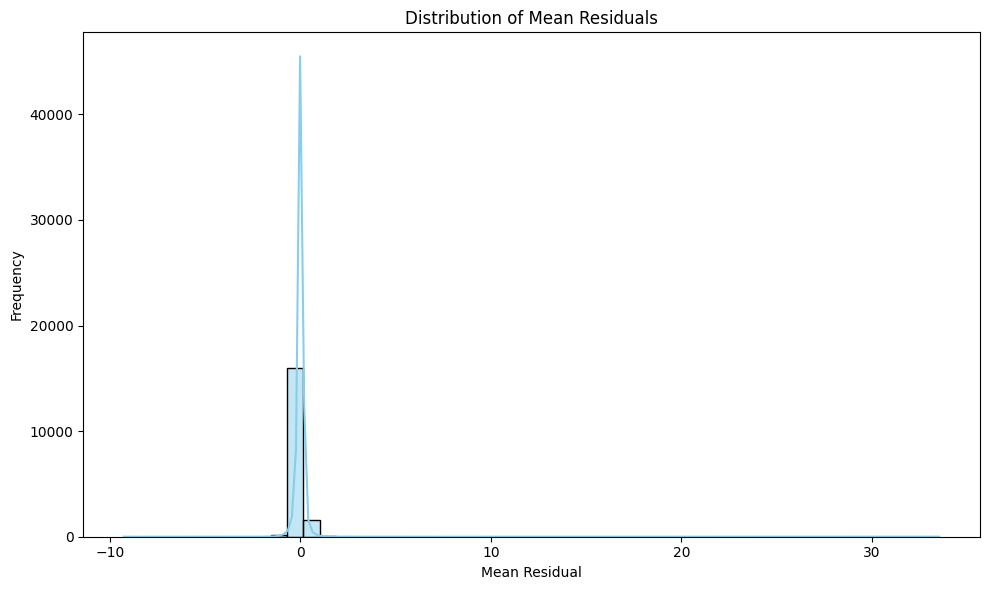

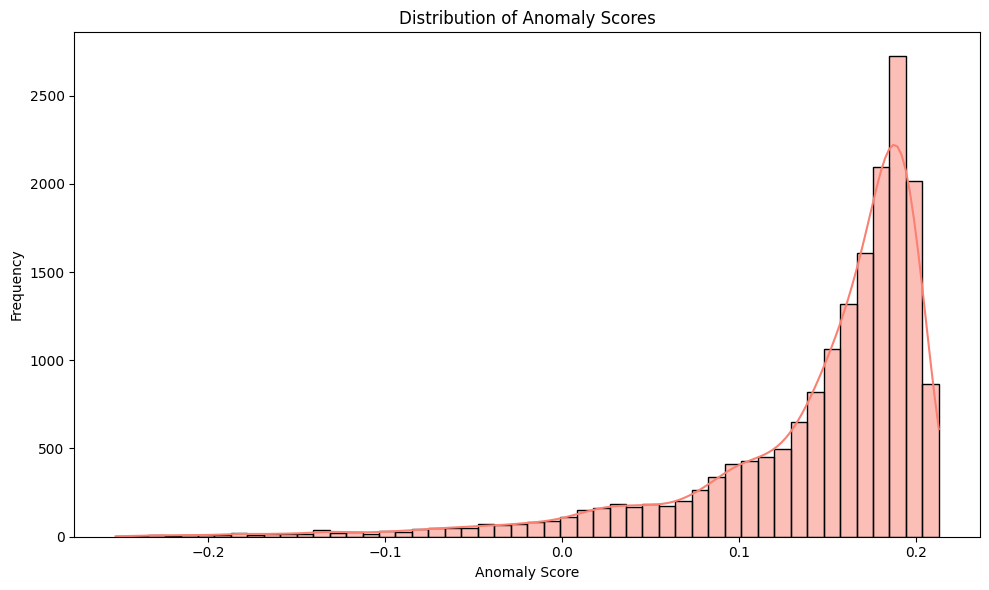

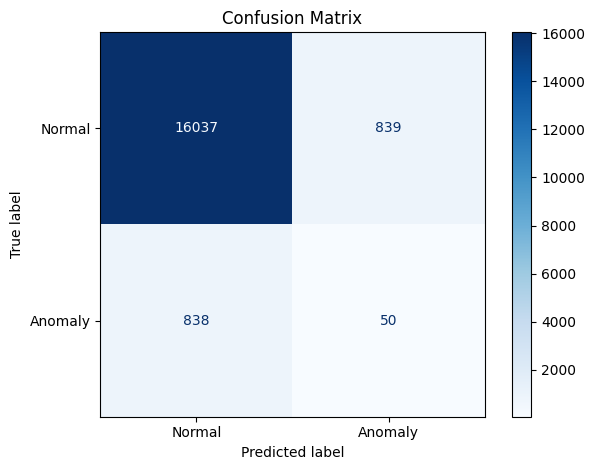

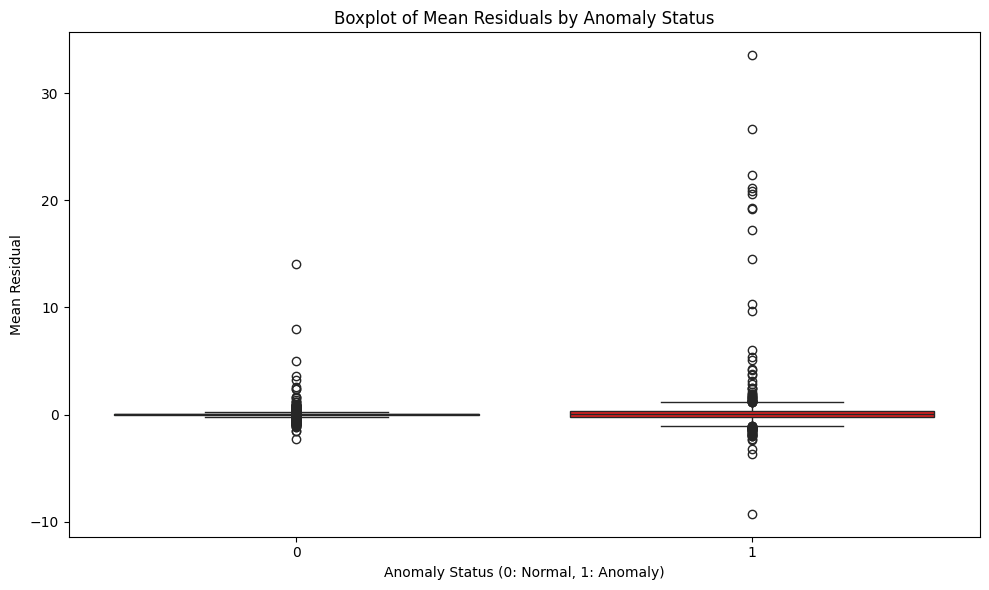

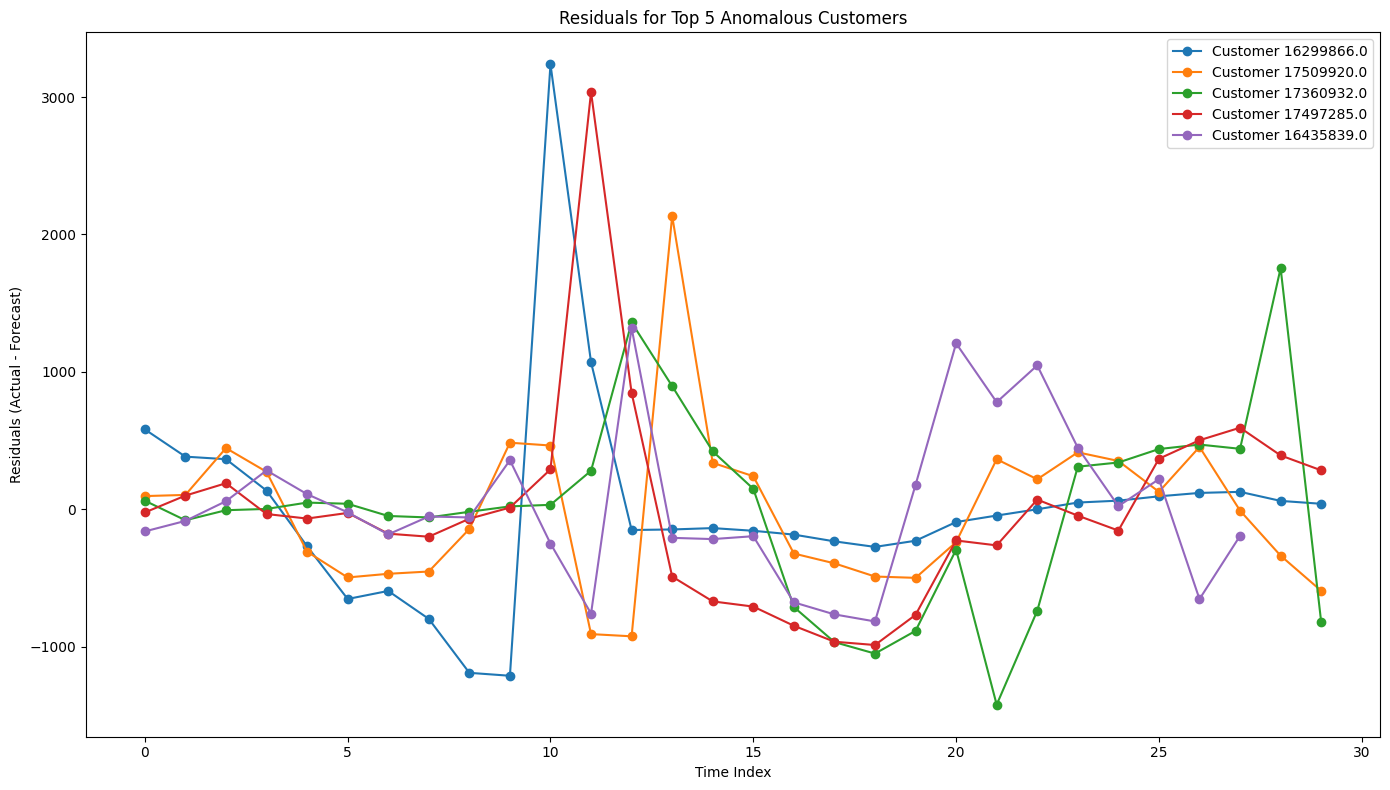

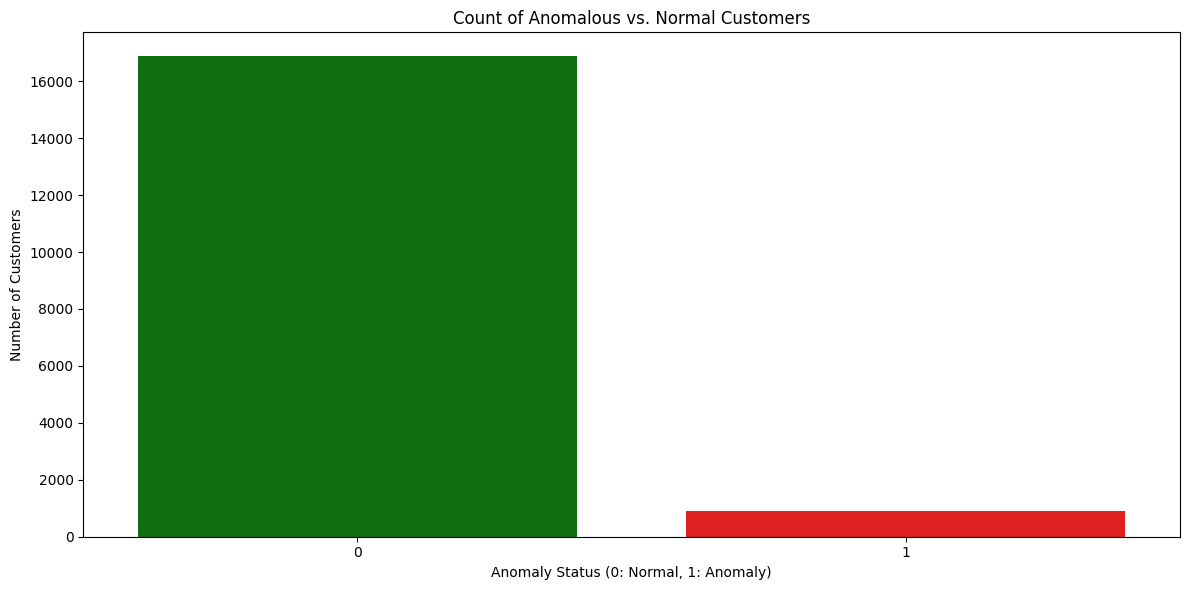

All visualizations have been saved in the 'visualizations' directory.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast  # For safely evaluating strings as Python literals
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# Step 1: Load the Data
# -----------------------------

# Define file paths
anomalies_detected_path = 'Prophet+IF_anomalies_detected.csv'
normal_customers_path = 'Prophet+IF_normal_customers.csv'
full_data_path = 'Prophet+IF_full_data_with_anomalies.csv'

# Load the datasets
anomalies_detected = pd.read_csv(anomalies_detected_path)
normal_customers = pd.read_csv(normal_customers_path)
full_data = pd.read_csv(full_data_path)

# -----------------------------
# Step 2: Convert Residuals from Strings to Lists
# -----------------------------

# Check if 'Residuals' column exists
if 'Residuals' in anomalies_detected.columns:
    try:
        # Convert the 'Residuals' column from string to list
        anomalies_detected['Residuals'] = anomalies_detected['Residuals'].apply(ast.literal_eval)
    except Exception as e:
        print(f"Error converting 'Residuals' to lists: {e}")
        raise
else:
    print("The 'Residuals' column is missing in anomalies_detected.csv.")
    raise KeyError("Missing 'Residuals' column.")

# -----------------------------
# Step 3: Create Directory for Visualizations
# -----------------------------

visualizations_dir = 'visualizations'
if not os.path.exists(visualizations_dir):
    os.makedirs(visualizations_dir)

# -----------------------------
# Step 4: Distribution of Residuals
# -----------------------------

plt.figure(figsize=(10, 6))
sns.histplot(anomalies_detected['Mean Residual'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Mean Residuals')
plt.xlabel('Mean Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'Distribution_Mean_Residuals.png'), dpi=300)
plt.show()

# -----------------------------
# Step 5: Distribution of Anomaly Scores
# -----------------------------

plt.figure(figsize=(10, 6))
sns.histplot(anomalies_detected['Anomaly Score'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'Distribution_Anomaly_Scores.png'), dpi=300)
plt.show()

# -----------------------------
# Step 6: Confusion Matrix
# -----------------------------

# Ensure that 'True Label' and 'Has Anomaly' are present
if 'True Label' in anomalies_detected.columns and 'Has Anomaly' in anomalies_detected.columns:
    y_true = anomalies_detected['True Label']
    y_pred = anomalies_detected['Has Anomaly']

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])

    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir, 'Confusion_Matrix.png'), dpi=300)
    plt.show()
else:
    print("Confusion Matrix cannot be generated. Ensure 'True Label' and 'Has Anomaly' columns exist.")

# -----------------------------
# Step 7: Residuals Boxplot by Anomaly Status
# -----------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(x='Has Anomaly', y='Mean Residual', data=anomalies_detected, palette=['green', 'red'])
plt.title('Boxplot of Mean Residuals by Anomaly Status')
plt.xlabel('Anomaly Status (0: Normal, 1: Anomaly)')
plt.ylabel('Mean Residual')
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'Boxplot_Mean_Residuals_Anomaly_Status.png'), dpi=300)
plt.show()

# -----------------------------
# Step 8: Detailed Residuals for Top Anomalous Customers
# -----------------------------

# Identify top 5 anomalous customers based on anomaly scores
top_5_anomalies = anomalies_detected.nsmallest(5, 'Anomaly Score')

plt.figure(figsize=(14, 8))
for idx, row in top_5_anomalies.iterrows():
    customer_id = row['Customer No']
    residuals = row['Residuals']
    timestamps = range(len(residuals))
    plt.plot(timestamps, residuals, marker='o', label=f'Customer {customer_id}')

plt.title('Residuals for Top 5 Anomalous Customers')
plt.xlabel('Time Index')
plt.ylabel('Residuals (Actual - Forecast)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'Detailed_Top_5_Anomalous_Customers.png'), dpi=300)
plt.show()

# -----------------------------
# Step 9: Count Plot of Anomalous vs. Normal Customers
# -----------------------------

plt.figure(figsize=(12, 6))
sns.countplot(x='Has Anomaly', data=anomalies_detected, palette=['green', 'red'])
plt.title('Count of Anomalous vs. Normal Customers')
plt.xlabel('Anomaly Status (0: Normal, 1: Anomaly)')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'Count_Anomalous_vs_Normal_Customers.png'), dpi=300)
plt.show()

# -----------------------------
# Step 10: Save Summary Statistics (Optional)
# -----------------------------

# Save summary statistics
summary_stats = anomalies_detected.describe()
summary_stats.to_csv(os.path.join(visualizations_dir, 'Summary_Statistics.csv'))

print(f"All visualizations have been saved in the '{visualizations_dir}' directory.")
